### Checklist for submission

It is extremely important to make sure that:

1. Everything runs as expected (no bugs when running cells);
2. The output from each cell corresponds to its code (don't change any cell's contents without rerunning it afterwards);
3. All outputs are present (don't delete any of the outputs);
4. Fill in all the places that say `YOUR CODE HERE`, or "**Your answer:** (fill in here)".
5. You **ONLY** change the parts of the code we asked you to, nowhere else (change only the coding parts saying `# YOUR CODE HERE`, nothing else);
6. Don't add any new cells to this notebook;
7. Fill in your group number and the full names of the members in the cell below;
8. Make sure that you are not running an old version of IPython (we provide you with a cell that checks this, make sure you can run it without errors).

Failing to meet any of these requirements might lead to either a subtraction of POEs (at best) or a request for resubmission (at worst).

We advise you the following steps before submission for ensuring that requirements 1, 2, and 3 are always met: **Restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). This might require a bit of time, so plan ahead for this (and possibly use Google Cloud's GPU in HA1 and HA2 for this step). Finally press the "Save and Checkout" button before handing in, to make sure that all your changes are saved to this .ipynb file.

---

Group number and member names:

In [1]:
GROUP = "36"
NAME1 = "Timothy Hellberg"
NAME2 = "Lars Liberg"

Make sure you can run the following cell without errors.

In [2]:
import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

---

# HA1 - Cats and dogs

<img src="http://lghttp.32478.nexcesscdn.net/80E972/organiclifestylemagazine/wp-content/uploads/2015/10/Cats-and-Dogs.jpg" alt="Cats and dogs" style="width: 5000px;"/>

For this home assignment, we'll use the Kaggle dataset for the [Dogs vs. Cats competition](https://www.kaggle.com/c/dogs-vs-cats). It is comprised of 25k colored images of dogs and cats. Our goal with this dataset will be to create a classifier that can tell us if the input image is of a cat or a dog.

As a way of helping you speed up the training process, each group gets 6 hours of access to an instance in Google Cloud with a K80 GPU. Take a look at the [Instructions folder](https://github.com/JulianoLagana/deep-machine-learning/tree/master/Instructions) to understand how to connect to this instance and use our tools there. You're free to use this resource as you see fit, but if you run out of hours you'll need a late day to obtain more (and you can only do this once).

In order to make the most out of your GPU hours, first try solving the initial part of this notebook (tasks 0-4) in your own computer (these tasks can be solved only on the CPU), and leave most of the available hours for solving tasks 5-6, and refining your best model further (and, if you have the spare hours, experiment a bit!).

Requirements:
- Whenever we ask you to plot anything, be sure to add a title and label the axes. If you're plotting more than one curve in the same plot, also add a legend.
- When we ask you to train an architecture, train it for a reasonable number of epochs. "Reasonable" here means you should be fairly confident that training for a higher number of epochs wouldn't impact your conclusions regarding the model's performance.

Tips:
- If you get errors saying you've exhausted the GPU resources, well, then you exhausted the GPU resources ;). However, sometimes that's because TensorFlow didn't release a part of the GPU's memory. If you think your CNN should fit in your memory during training, try restarting the kernel and directly training only that architecture.
- Every group has enough credits on google cloud to complete this assignment. However, this statement assumes you'll use your resources judiciously (e.g. always try the code first in your machine and make sure everything works properly before starting your instances) and **won't forget to stop your instance after using it,**  otherwise you might run out of credits.
- Before starting, take a look at the images we'll be using. This is a hard task, don't get discouraged if your first models perform poorly (several participants in the original competition didn't achieve an accuracy higher than 60%).

---
## 0. Imports

In the following cell, add all the imports you'll use in this assignment.

In [3]:
# YOUR CODE HERE
# For dealing with files
import os
import shutil

# For using regex expressions
import re

# For splitting the data
from sklearn.model_selection import train_test_split

# Packages for defining the architecture of our model
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Input, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import regularizers
from keras.optimizers import Adam
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model

# For generating data
from keras.preprocessing.image import ImageDataGenerator

# One-hot encoding
from keras.utils import np_utils

# Callbacks for training
from keras.callbacks import TensorBoard, EarlyStopping

# Ploting
import matplotlib.pyplot as plt
%matplotlib inline

# Ndarray computations
import numpy as np

# Confusion matrix for assessment step
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.
/Users/timhell/anaconda3/envs/dml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


---
## 1. Loading the data and preprocessing

The first step is to head to the [Kaggle website for the cats and dogs competition](https://www.kaggle.com/c/dogs-vs-cats) and download the data from there. You should download both the test and train folders together in one zip file (by clicking the download all button). The split ratio between training and validation has not been made, you'll need to do it yourself. The `test.zip` file contains unlabeled data, so that participants in the contest are not able to train on this set.

For this assignment you should use [data generators](https://keras.io/preprocessing/image/) to load the images to your CPU/GPU memory. Because of this, your folder structure for the data should conform to the folder structure expected by the data generators (i.e. the samples should be separated into one folder for each class). Furthermore, we ask you to first start with a smaller subset of the data (1/5 of the number of samples), in order to test different models faster.

This means that you should create a folder structure that resembles the following (obviously, the folder names are up to you):


         small_train             small_val                train                   val
              |                      |                      |                      |
              |                      |                      |                      |
        -------------          -------------          -------------          -------------
        |           |          |           |          |           |          |           |
        |           |          |           |          |           |          |           |
      Cats        Dogs       Cats        Dogs       Cats        Dogs       Cats        Dogs

The `small_train` and `small_val` folders have the training and validation samples for your smaller subset of the data, while the `train` and `val` folders contain all the samples you extracted from Kaggle's `train.zip`. We provide you a notebook that shows how to achieve this ("Create project structure.ipynb"), starting from the original `all.zip` file that you download from Kaggle. If you do use that notebook, we encourage you to understand how each step is being done, so you can generalize this knowledge to new datasets you'll encounter.

We advise you to use 30% of the data as validation data in the smaller dataset. However, for the larger dataset, you should decide how to split between training and validation. Please specify your splits in the following cells.

For the larger subset, what was the training/validation split that you decided to use?

**% Samples in the training set:**

In [4]:
# YOUR CODE HERE

# Here we assume that the user is in the folder HA1 after running "Create project structure"

# train paths
home_path = os.getcwd()
train_cats_path = home_path + "/train/cats"
train_dogs_path = home_path + "/train/dogs"

# get sample sizes
os.chdir(train_cats_path)
m_train_cats = len(os.listdir())
os.chdir(train_dogs_path)
m_train_dogs = len(os.listdir())
os.chdir(home_path)

m_train = m_train_cats + m_train_dogs
print('Number of samples in training set: ',m_train)

Number of samples in training set:  20000


**% Samples in the validation set:**

In [5]:
# YOUR CODE HERE

# val paths
val_cats_path = home_path + "/val/cats"
val_dogs_path = home_path + "/val/dogs"

# get sample sizes
os.chdir(val_cats_path)
m_val_cats = len(os.listdir())
os.chdir(val_dogs_path)
m_val_dogs = len(os.listdir())
os.chdir(home_path)

m_val = m_val_cats + m_val_dogs 
print('Number of samples in validation set: ',m_val)

Number of samples in validation set:  5000


Fill in the dataset paths (to be used later by your data generators):

In [6]:
# YOUR CODE HERE

# large dataset paths
test_path = home_path + "/test"
train_path = home_path + "/train"
train_cats_path = home_path + "/train/cats"
train_dogs_path = home_path + "/train/dogs"
val_path = home_path + "/val"
val_cats_path = home_path + "/val/cats"
val_dogs_path = home_path + "/val/dogs"

# small dataset paths
small_train_path = home_path + "/small_train"
small_train_cats_path = home_path + "/small_train/cats"
small_train_dogs_path = home_path + "/small_train/dogs"
small_val_path = home_path + "/small_val"
small_val_cats_path = home_path + "/small_val/cats"
small_val_dogs_path = home_path + "/small_val/dogs"


---
Once you have the expected folder structure, create two data generators for automatically generating batches from the images in your smaller subset of data. Don't use any [data augmentation](https://cartesianfaith.com/2016/10/06/what-you-need-to-know-about-data-augmentation-for-machine-learning/), but feel free to preprocess the data as you see fit. After instantiating them, run the `flow_from_directory` method with the desired arguments.

Hints:
- The specified `batch_size` should be chosen so that your don't run out of memory.
- When feeding the images to your CNN, you'll probably want all of them to have the same spatial size, even though the .jpeg files differ in this. If so, take a look at the argument `target_size` for the `flow_from_directory` method of data generators.
- Resizing the images to a smaller size while loading them can be beneficial.

In [7]:
# YOUR CODE HERE

# settings for generators
train_directory = small_train_path
val_directory = small_val_path
size = 128
target_size=(size, size)
color_mode='rgb'
classes=['dogs', 'cats']
class_mode='categorical'
batch_size=32
shuffle=True
seed=None
save_to_dir=None
save_prefix=''
save_format='jpg'
follow_links=False
subset=None
interpolation='nearest'

train_generator = ImageDataGenerator()
train_iterator = train_generator.flow_from_directory(train_directory, target_size, color_mode, classes, class_mode, batch_size, shuffle, seed, save_to_dir, save_prefix, save_format, follow_links, subset, interpolation)

val_generator = ImageDataGenerator()
val_iterator = train_generator.flow_from_directory(val_directory, target_size, color_mode, classes, class_mode, batch_size, shuffle, seed, save_to_dir, save_prefix, save_format, follow_links, subset, interpolation)



Found 3500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.


---
## 2. Training

Create your first CNN architecture for this task. Start with something as simple as possible, that you're almost sure can get an accuracy better than 50% (we'll improve upon it later).

Tip:
- If Tensorflow is your backend, your `input_shape` is always `(img_width, img_height, 3)` (i.e. channels **last**)

In [8]:
# YOUR CODE HERE

# Create model
model = Sequential()
model.add(Conv2D(128, (5, 5), input_shape=(size, size, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))
    
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Train your model using the `fit_generator` method and the two data generators you created earlier. Train for a reasonable amount of epochs, so as to get a good sense of how well this architecture performs.

Tips:
- Usually the bottleneck is when loading the images from the disk. To speed up training, make sure to take a look at the arguments `workers` and `use_multiprocessing` of `fit_generator`.
- You don't have to set the argument `steps_per_epoch` to the number of batches in an epoch. Instead, you can choose a lower number to obtain more frequent prints about the current loss and accuracy of your model (but then have in mind that you're not actually training for the number of epochs you specify in `epochs`).

In [9]:
# YOUR CODE HERE

# Input data
generator = train_iterator
validation_data = val_iterator

# Training
steps_per_epoch=350*3/batch_size
epochs=30
verbose=1
callbacks=None
validation_steps=None
class_weight=None 
max_queue_size=10
workers=4
use_multiprocessing=True
shuffle=True
initial_epoch=0

history1 = model.fit_generator(
    generator=generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=verbose,
    callbacks=callbacks,
    validation_data=validation_data,
    validation_steps=validation_steps,
    class_weight=class_weight,
    max_queue_size=max_queue_size,
    workers=workers,
    use_multiprocessing=use_multiprocessing,
    shuffle=shuffle,
    initial_epoch=initial_epoch)

Epoch 1/30
33/32 [==============================] - 292s 9s/step - loss: 1.3581 - acc: 0.5682 - val_loss: 0.8826 - val_acc: 0.5880
Epoch 2/30
33/32 [==============================] - 290s 9s/step - loss: 0.7002 - acc: 0.6117 - val_loss: 0.7597 - val_acc: 0.6107
Epoch 3/30
33/32 [==============================] - 291s 9s/step - loss: 0.6442 - acc: 0.6070 - val_loss: 0.9036 - val_acc: 0.5800
Epoch 4/30
33/32 [==============================] - 289s 9s/step - loss: 0.5584 - acc: 0.7170 - val_loss: 1.7504 - val_acc: 0.5040
Epoch 5/30
33/32 [==============================] - 290s 9s/step - loss: 0.4884 - acc: 0.7680 - val_loss: 2.8948 - val_acc: 0.5000
Epoch 6/30
33/32 [==============================] - 288s 9s/step - loss: 0.5040 - acc: 0.7334 - val_loss: 1.1945 - val_acc: 0.5193
Epoch 7/30
33/32 [==============================] - 291s 9s/step - loss: 0.4523 - acc: 0.7794 - val_loss: 0.7366 - val_acc: 0.6320
Epoch 8/30
33/32 [==============================] - 290s 9s/step - loss: 0.3451 - a

Create one figure with two axes. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

Hint:
- The `fit_generator` method returns a `history` object.

<class 'keras.callbacks.History'>


Text(0,0.5,'Accuracy')

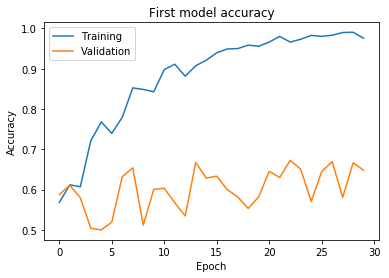

In [10]:
# YOUR CODE HERE

fig, axes = plt.subplots()
print(type(history1))
axes.plot(history1.history['acc'])
axes.plot(history1.history['val_acc'])
plt.legend(['Training','Validation'])
plt.title('First model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Based on these, what would you suggest for improving your model? Why?

**Your answer:** Since the validation accuracy is much lower than the training accuracy, it means that we are overfitting the data. In order to reduce variance, we should add regularization and lower the filter size. In order to prevent the bias from becomming too large, we should add more layers.

---
## 3. Improving your initial model

Improve your initial model according to you answer above. Write the new definition in the cell below and train it.

In [11]:
# YOUR CODE HERE

def two_convlayers_model_fewer_filters_with_reg(): 
    # lowered bias thanks to more layers and lowered variance with regularization, 
    # better performance than two_convlayers_model
    lam = 0.01 # penalty parameter
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(size, size, 3), activation='relu',
              kernel_regularizer=regularizers.l2(lam)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu',
              kernel_regularizer=regularizers.l2(lam)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(lam)))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create model
model = two_convlayers_model_fewer_filters_with_reg()

# Input data
generator = train_iterator
validation_data = val_iterator

# Training
steps_per_epoch=350*3/batch_size
epochs=30
verbose=1
callbacks=None
validation_steps=None
class_weight=None 
max_queue_size=10
workers=4
use_multiprocessing=True
shuffle=True
initial_epoch=0

history2 = model.fit_generator(
    generator=generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=verbose,
    callbacks=callbacks,
    validation_data=validation_data,
    validation_steps=validation_steps,
    class_weight=class_weight ,
    max_queue_size=max_queue_size,
    workers=workers,
    use_multiprocessing=use_multiprocessing,
    shuffle=shuffle,
    initial_epoch=initial_epoch)

Epoch 1/30
33/32 [==============================] - 108s 3s/step - loss: 4.3898 - acc: 0.6023 - val_loss: 4.1434 - val_acc: 0.5767
Epoch 2/30
33/32 [==============================] - 103s 3s/step - loss: 3.1193 - acc: 0.6219 - val_loss: 2.8392 - val_acc: 0.5633
Epoch 3/30
33/32 [==============================] - 105s 3s/step - loss: 2.1972 - acc: 0.6496 - val_loss: 2.4071 - val_acc: 0.5707
Epoch 4/30
33/32 [==============================] - 106s 3s/step - loss: 1.7397 - acc: 0.7027 - val_loss: 1.6295 - val_acc: 0.6473
Epoch 5/30
33/32 [==============================] - 105s 3s/step - loss: 1.4805 - acc: 0.7491 - val_loss: 1.5334 - val_acc: 0.6607
Epoch 6/30
33/32 [==============================] - 106s 3s/step - loss: 1.5270 - acc: 0.6913 - val_loss: 1.4895 - val_acc: 0.6600
Epoch 7/30
33/32 [==============================] - 103s 3s/step - loss: 1.3717 - acc: 0.7104 - val_loss: 1.4623 - val_acc: 0.6433
Epoch 8/30
33/32 [==============================] - 105s 3s/step - loss: 1.2868 - a

How does the model perform, compared to the initial model? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

<class 'keras.callbacks.History'>


Text(0,0.5,'Accuracy')

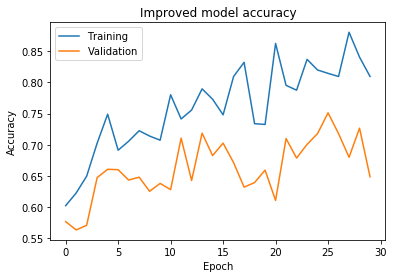

In [12]:
# YOUR CODE HERE

fig, axes = plt.subplots()
print(type(history2))
axes.plot(history2.history['acc'])
axes.plot(history2.history['val_acc'])
plt.legend(['Training','Validation'])
plt.title('Improved model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Did your results improve? Explain why, or why not.

**Your answer:** The results did improve, but not by much. The validation score become slighly better since we added more layers but the training score decreased because of heavy regularization. We should therefore lower the regularization effect to raise the training score. Since the model still overfits, we should also try more layers.

---
## 4. Obtaining the *best* model

Continue to improve your model architecture by comparing the value of the metrics you're interested in both the training and validation set. Try different ideas, and consider comparing them using tensorboard. When you're happy with one architecture, copy it in the cell below and train it here. Save the optimization history (i.e. the `history` object returned by the `fit_generator`). You'll use this later to compare your best model with the one using transfer learning.

**Note**: When trying different ideas, you'll end up with several different models. However, when submitting your solutions to ping-pong, the cell below must contain only the definition and training of *one* model. Remove all code related to the models that were not chosen.

In [13]:
# YOUR CODE HERE

def four_convlayers_model_fewer_filters_with_reg(): 
    # much better performance, lowered the bias with more layers and lowered lambda. Achieved 75% val_acc
    lam = 0.005
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), input_shape=(size, size, 3), activation='relu',
              kernel_regularizer=regularizers.l2(lam)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu',
              kernel_regularizer=regularizers.l2(lam)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu',
              kernel_regularizer=regularizers.l2(lam)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu',
              kernel_regularizer=regularizers.l2(lam)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(lam)))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = four_convlayers_model_fewer_filters_with_reg()

estop = EarlyStopping(monitor='val_acc', patience=20)

# Input data
generator = train_iterator
validation_data = val_iterator

# Training
steps_per_epoch=350*3/batch_size
epochs=30
verbose=1
callbacks=[estop]
validation_steps=None
class_weight=None 
max_queue_size=10
workers=4
use_multiprocessing=True
shuffle=True
initial_epoch=0

history3 = model.fit_generator(
    generator=generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=verbose,
    callbacks=callbacks,
    validation_data=validation_data,
    validation_steps=validation_steps,
    class_weight=class_weight ,
    max_queue_size=max_queue_size,
    workers=workers,
    use_multiprocessing=use_multiprocessing,
    shuffle=shuffle,
    initial_epoch=initial_epoch)

Epoch 1/30
33/32 [==============================] - 115s 3s/step - loss: 2.9434 - acc: 0.6092 - val_loss: 2.8909 - val_acc: 0.6013
Epoch 2/30
33/32 [==============================] - 114s 3s/step - loss: 2.6418 - acc: 0.6061 - val_loss: 2.8964 - val_acc: 0.5607
Epoch 3/30
33/32 [==============================] - 114s 3s/step - loss: 2.4269 - acc: 0.6345 - val_loss: 2.3348 - val_acc: 0.6487
Epoch 4/30
33/32 [==============================] - 114s 3s/step - loss: 2.1695 - acc: 0.7333 - val_loss: 2.2042 - val_acc: 0.6673
Epoch 5/30
33/32 [==============================] - 114s 3s/step - loss: 2.0343 - acc: 0.7263 - val_loss: 2.0806 - val_acc: 0.6400
Epoch 6/30
33/32 [==============================] - 114s 3s/step - loss: 1.9101 - acc: 0.7453 - val_loss: 2.0103 - val_acc: 0.6447
Epoch 7/30
33/32 [==============================] - 115s 3s/step - loss: 1.7250 - acc: 0.7765 - val_loss: 1.7921 - val_acc: 0.7147
Epoch 8/30
33/32 [==============================] - 114s 3s/step - loss: 1.6103 - a

Create one figure with two axes. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

<class 'keras.callbacks.History'>


Text(0,0.5,'Accuracy')

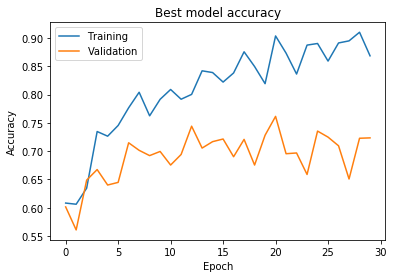

In [14]:
# YOUR CODE HERE

fig, axes = plt.subplots()
print(type(history3))
axes.plot(history3.history['acc'])
axes.plot(history3.history['val_acc'])
plt.legend(['Training','Validation'])
plt.title('Best model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

[Save your model](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) to disk as a HDF5 file (the architecture, weights and optimizer state). This is simply so you can use it again easily in the later parts of the notebook, without having to keep it in memory or re-training it. The actual `.h5` files you create are not relevant to your ping-pong submission.

In [15]:
model.save('best_own_model.h5')

---
## 5. Transfer Learning

Now, instead of trying to come up with a good architecture for this task, we'll use the VGG16 architecture, but with the top layers removed (the fully connected + classification layers). We'll substitute them with a single fully connected layer, and a classification layer that makes sense for our problem.

However, this model has a very high capacity, and will probably suffer a lot from overfitting if we try to train it from scratch, using only our small subset of data. Instead, we'll start the optimization with the weights obtained after training VGG16 on the ImageNet dataset.

Start by loading the VGG16 model without the top layers, from the `applications` submodule from Keras. Make sure to also load the weights obtained from the ImageNet pretraining.

In [31]:
# YOUR CODE HERE

# VGG16 parameters
include_top=False 
# whether to include the 3 fully-connected layers at the top of the network.
weights='imagenet' 
# one of None (random initialization) or 'imagenet' (pre-training on ImageNet).
input_tensor=None #Input(shape=(size,size,3)) 
# optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model.
input_shape=(size,size,3) 
# optional shape tuple, only to be specified if include_top is False 
# (otherwise the input shape has to be  (224, 224, 3) (with 'channels_last' data format) 
# or (3, 224, 224) (with 'channels_first' data format). It should have exactly 3 inputs channels, 
# and width and height should be no smaller than 32. E.g. (200, 200, 3) would be one valid value.
pooling=None 
# Optional pooling mode for feature extraction when include_top is False. 
# None means that the output of the model will be the 4D tensor output of the last convolutional layer.
# 'avg' means that global average pooling will be applied to the output of the last convolutional layer, 
#       and thus the output of the model will be a 2D tensor.
# 'max' means that global max pooling will be applied.
classes=None 
# optional number of classes to classify images into, only to be specified if include_top is True, and if no weights argument is specified

vgg16_model = VGG16(include_top=include_top, 
                    weights=weights, 
                    input_tensor=input_tensor, 
                    input_shape=input_shape, 
                    pooling=pooling, 
                    classes=classes)


Create a new model with the layers you want to add on top of VGG. The kernels and bias in these layers should be initialized randomly.

In [32]:
# YOUR CODE HERE

def add_top_model(output_vgg16_model):
    model = Flatten()(output_vgg16_model)
    model = Dense(64, activation='relu',                         
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform')(model)
    model = Dense(64, activation='relu',
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform')(model)
    model = Dense(2, activation='softmax')(model)
    return model

Now add the new model on top of VGG.

Tip:
- The VGG model you loaded from the `applications` submodule is from the [`Model`](https://keras.io/models/model/) class, not the `Sequential` class, so it doesn't have some methods you're used to (like `add`, for instance). It might be helpful to read [this introduction to the Model class](https://keras.io/getting-started/functional-api-guide/).

In [33]:
# YOUR CODE HERE

input = Input(shape=(size,size,3),name = 'image_input')
output_vgg16_model = vgg16_model(input)

# Add top model
full_model = add_top_model(output_vgg16_model)
complete_model = Model(inputs=input, outputs=full_model)
print(complete_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 128, 128, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                524352    
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 130       
Total params: 15,243,330
Trainable params: 15,243,330
Non-trainable params: 0
________________________________________________________________

### 5.1 Using VGG features

Now we're almost ready to train the new model. However, since the top layers of this architecture are being initialized randomly, it's sometimes possible for them to generate large gradients that can wreck the pretraining of the bottom layers. To avoid this, freeze all the VGG layers in your architecture (i.e. signal to the optimizer that these should not be changed during optimization) by setting the `trainable` attribute of them to `False`.

In [34]:
# YOUR CODE HERE

# Lock the VGG16 layers
complete_model.layers[1].trainable = False
print(complete_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 128, 128, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                524352    
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 130       
Total params: 15,243,330
Trainable params: 528,642
Non-trainable params: 14,714,688
__________________________________________________________

Create the callbacks (if any) you would like to use, compile the model and train it.

In [35]:
# YOUR CODE HERE

# Compile and train
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

complete_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

estop = EarlyStopping(monitor='val_acc', patience=5)

# Input data
generator = train_iterator
validation_data = val_iterator

steps_per_epoch=350*3/batch_size
epochs=30
verbose=1
callbacks=[estop]
validation_steps=None
class_weight=None 
max_queue_size=10
workers=4
use_multiprocessing=True
shuffle=True
initial_epoch=0

history_vgg_train_top = complete_model.fit_generator(
    generator=generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=verbose,
    callbacks=callbacks,
    validation_data=validation_data,
    validation_steps=validation_steps,
    class_weight=class_weight ,
    max_queue_size=max_queue_size,
    workers=workers,
    use_multiprocessing=use_multiprocessing,
    shuffle=shuffle,
    initial_epoch=initial_epoch)

Epoch 1/30
33/32 [==============================] - 431s 13s/step - loss: 1.3990 - acc: 0.7198 - val_loss: 0.7336 - val_acc: 0.8153
Epoch 2/30
33/32 [==============================] - 445s 13s/step - loss: 0.7291 - acc: 0.8371 - val_loss: 0.5275 - val_acc: 0.8580
Epoch 3/30
33/32 [==============================] - 406s 12s/step - loss: 0.5777 - acc: 0.8409 - val_loss: 0.4697 - val_acc: 0.8647
Epoch 4/30
33/32 [==============================] - 419s 13s/step - loss: 0.3378 - acc: 0.8996 - val_loss: 0.3938 - val_acc: 0.8867
Epoch 5/30
33/32 [==============================] - 414s 13s/step - loss: 0.2151 - acc: 0.9331 - val_loss: 0.3966 - val_acc: 0.8800
Epoch 6/30
33/32 [==============================] - 411s 12s/step - loss: 0.1948 - acc: 0.9309 - val_loss: 0.3669 - val_acc: 0.8867
Epoch 7/30
33/32 [==============================] - 419s 13s/step - loss: 0.1416 - acc: 0.9593 - val_loss: 0.3493 - val_acc: 0.8867
Epoch 8/30
33/32 [==============================] - 420s 13s/step - loss: 0.

Create one figure with two axes. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

Text(0,0.5,'Accuracy')

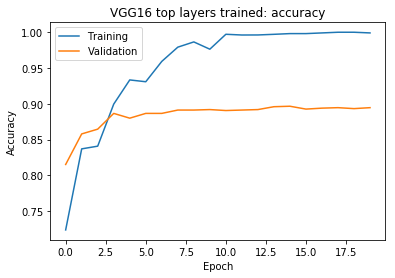

In [36]:
# YOUR CODE HERE

fig, axes = plt.subplots()
axes.plot(history_vgg_train_top.history['acc'])
axes.plot(history_vgg_train_top.history['val_acc'])
plt.legend(['Training','Validation'])
plt.title('VGG16 top layers trained: accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

How does the model perform, compared to the model obtained in step 4? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

Text(0,0.5,'Accuracy')

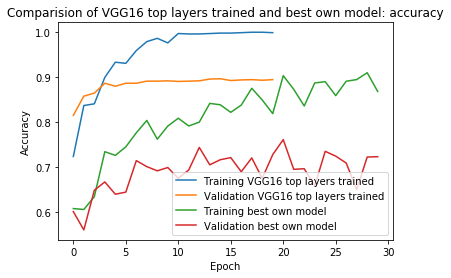

In [37]:
# YOUR CODE HERE

fig, axes = plt.subplots()
axes.plot(history_vgg_train_top.history['acc'])
axes.plot(history_vgg_train_top.history['val_acc'])
axes.plot(history3.history['acc'])
axes.plot(history3.history['val_acc'])
plt.legend(['Training VGG16 top layers trained','Validation VGG16 top layers trained',
            'Training best own model','Validation best own model'])
plt.title('Comparision of VGG16 top layers trained and best own model: accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Compare these results. Which approach worked best, starting from scratch or doing transfer learning? Explain how you evaluated this.

**Your answer:** The transfer learning worked better, which can be seen from the above plot. The validation accuracy reached a much higher score and it has less bias (higher training score).

What are the main differences between the ImageNet dataset and the Dogs vs Cats dataset we used?

**Your answer:** ImageNet contains thousands of classes (including multiples classes of different dog and cat breeds) while our dataset only has two classes and does not distinguish between different breeds.

Even though there are considerable differences between these datasets, why is it that transfer learning is still a good idea?

**Your answer:** Since the ImageNet contains classes for cats and dogs, VGG16 has already been trained to understand the difference between dogs and cats. But the ImageNet dataset is much much larger than our dataset so even though ImageNet contains many more classes, the distinction between cats and dogs can be trained much better.

In which scenario would transfer learning be unsuitable?

**Your answer:** If the transfered weights were trained on data which does not contain the appropriate classes, it does not matter that the dataset was large. For example, if the transfered weights were trained on recognizing chairs and tables, it would not help us since there are very few relevant features that animals and furniture share.

Save the model to a HDF5 file.

In [38]:
complete_model.save('trans_learning_top_only.h5')

### 5.2 Fine-tuning

Now that we have a better starting point for the top layers, we can train the entire network. Unfreeze the bottom layers.

Tip:
- Always recompile your model after changing anything in it!

In [41]:
# YOUR CODE HERE

complete_model = load_model('trans_learning_top_only.h5')
# Unfreeze VGG16 layers
complete_model.layers[1].trainable = True
print(complete_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 128, 128, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                524352    
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 130       
Total params: 15,243,330
Trainable params: 15,243,330
Non-trainable params: 0
________________________________________________________________

/Users/timhell/anaconda3/envs/dml/lib/python3.6/site-packages/keras/engine/saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Create the callbacks (if any) you would like to use for this training here, compile the model, and train it.

Tip:
- Even though we do have a decent starting point for the optimization, it's still possible that a bad hyper-parameter choice wrecks the preinitialization. Make sure to use a small learning rate for this step.

In [42]:
# YOUR CODE HERE

# Compile and train
optimizer = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

complete_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

estop = EarlyStopping(monitor='val_acc', patience=3)

# Input data
generator = train_iterator
validation_data = val_iterator

steps_per_epoch=350*3/batch_size
epochs=10
verbose=1
callbacks=[estop]
validation_steps=None
class_weight=None 
max_queue_size=10
workers=6
use_multiprocessing=True
shuffle=True
initial_epoch=0

history_vgg_train_all = complete_model.fit_generator(
    generator=generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=verbose,
    callbacks=callbacks,
    validation_data=validation_data,
    validation_steps=validation_steps,
    class_weight=class_weight ,
    max_queue_size=max_queue_size,
    workers=workers,
    use_multiprocessing=use_multiprocessing,
    shuffle=shuffle,
    initial_epoch=initial_epoch)
 

Epoch 1/10
33/32 [==============================] - 825s 25s/step - loss: 0.0496 - acc: 0.9867 - val_loss: 0.3613 - val_acc: 0.8967
Epoch 2/10
33/32 [==============================] - 784s 24s/step - loss: 0.0605 - acc: 0.9744 - val_loss: 0.3774 - val_acc: 0.9207
Epoch 3/10
33/32 [==============================] - 784s 24s/step - loss: 0.0634 - acc: 0.9744 - val_loss: 0.3447 - val_acc: 0.9147
Epoch 4/10
33/32 [==============================] - 792s 24s/step - loss: 0.0327 - acc: 0.9858 - val_loss: 0.3995 - val_acc: 0.9073
Epoch 5/10
33/32 [==============================] - 798s 24s/step - loss: 0.0228 - acc: 0.9886 - val_loss: 0.4112 - val_acc: 0.9140


How does the model perform, compared to the model trained with freezed layers? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

Text(0,0.5,'Accuracy')

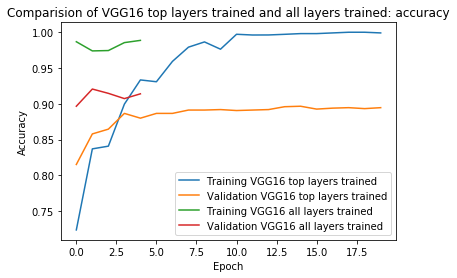

In [43]:
# YOUR CODE HERE
fig, axes = plt.subplots()
axes.plot(history_vgg_train_top.history['acc'])
axes.plot(history_vgg_train_top.history['val_acc'])
axes.plot(history_vgg_train_all.history['acc'])
axes.plot(history_vgg_train_all.history['val_acc'])
plt.legend(['Training VGG16 top layers trained','Validation VGG16 top layers trained',
            'Training VGG16 all layers trained','Validation VGG16 all layers trained'])
plt.title('Comparision of VGG16 top layers trained and all layers trained: accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Did the model's performance improve? Why (why not)?

**Your answer:** The performance increased by a bit. The final validation accuracy is 0.91 compared to 0.89, and this is done using only the small dataset. For this model, only 5 epochs were completed since the validation score did not increase after the second epoch (the patience was set to 3). The performance improved since we now adjust the VGG16 layers to better fit our dataset consisting of only cats and dogs.

Save the model to a HDF5 file.

In [44]:
complete_model.save('trans_learning_full.h5')

### 5.3 Improving the top model (optional)

Improve the architecture for the layers you add on top of VGG16. Try different ideas, and consider comparing them using tensorboard. When you're happy with one architecture, copy it in the cell below and train it here.

In [ ]:
# YOUR CODE HERE

How does the model perform, compared to the model trained in step 5.2? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

In [ ]:
# YOUR CODE HERE

Save the model to a HDF5 file.

In [ ]:
#model.save('best_trans_learning.h5')

## 6. Final training

Now we'll train the model that achieved the best performance so far using the entire dataset.

**Note**: start the optimization with the weights you obtained training in the smaller subset, i.e. *not* from scratch.

First, create two new data generators, one for training samples and one for validation samples. This time, they'll load data from the folders for the entire dataset.

In [48]:
# YOUR CODE HERE

large_dataset_model = load_model('trans_learning_full.h5')

# Creating generators
train_directory = train_path
val_directory = val_path
size = 128
target_size=(size, size)
color_mode='rgb'
classes=['dogs', 'cats']
class_mode='categorical'
batch_size=64
shuffle=True
seed=None
save_to_dir=None
save_prefix=''
save_format='jpg'
follow_links=False
subset=None
interpolation='nearest'

train_generator = ImageDataGenerator()
train_iterator = train_generator.flow_from_directory(train_directory, target_size, color_mode, classes, class_mode, batch_size, shuffle, seed, save_to_dir, save_prefix, save_format, follow_links, subset, interpolation)

val_generator = ImageDataGenerator()
val_iterator = val_generator.flow_from_directory(val_directory, target_size,color_mode, classes, class_mode, batch_size, shuffle, seed, save_to_dir, save_prefix, save_format, follow_links, subset, interpolation)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


Create the callbacks you would like to use and train your model. This optimization might take a long time, so TensorBoard is advised ;).

In [49]:
# YOUR CODE HERE

# Compile, callback, and train
optimizer = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

large_dataset_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

estop = EarlyStopping(monitor='val_acc', patience=10)

# Input data
generator = train_iterator
validation_data = val_iterator

steps_per_epoch=2000/batch_size
epochs=5
verbose=1
callbacks=[estop]
validation_steps=None
class_weight=None 
max_queue_size=10
workers=4
use_multiprocessing=True
shuffle=True
initial_epoch=0

history_vgg_large_dataset = large_dataset_model.fit_generator(
    generator=generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=verbose,
    callbacks=callbacks,
    validation_data=validation_data,
    validation_steps=validation_steps,
    class_weight=class_weight ,
    max_queue_size=max_queue_size,
    workers=workers,
    use_multiprocessing=use_multiprocessing,
    shuffle=shuffle,
    initial_epoch=initial_epoch)

os.chdir(home_path)
large_dataset_model.save('large_dataset.h5')

Epoch 1/5
32/31 [==============================] - 1952s 61s/step - loss: 0.2951 - acc: 0.9087 - val_loss: 0.2558 - val_acc: 0.9134
Epoch 2/5
32/31 [==============================] - 1950s 61s/step - loss: 0.2088 - acc: 0.9390 - val_loss: 0.2288 - val_acc: 0.9362
Epoch 3/5
32/31 [==============================] - 1961s 61s/step - loss: 0.2073 - acc: 0.9307 - val_loss: 0.2035 - val_acc: 0.9260
Epoch 4/5
32/31 [==============================] - 1952s 61s/step - loss: 0.1893 - acc: 0.9307 - val_loss: 0.1704 - val_acc: 0.9376
Epoch 5/5
32/31 [==============================] - 1946s 61s/step - loss: 0.1605 - acc: 0.9370 - val_loss: 0.1605 - val_acc: 0.9390


How does the model perform now when trained on the entire dataset, compared to when only trained on the smaller subset of data? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

Text(0,0.5,'Accuracy')

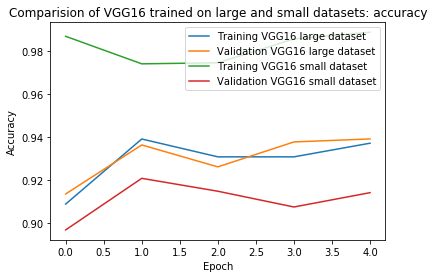

In [50]:
# YOUR CODE HERE

fig, axes = plt.subplots()
axes.plot(history_vgg_large_dataset.history['acc'])
axes.plot(history_vgg_large_dataset.history['val_acc'])
axes.plot(history_vgg_train_all.history['acc'])
axes.plot(history_vgg_train_all.history['val_acc'])
plt.legend(['Training VGG16 large dataset','Validation VGG16 large dataset',
            'Training VGG16 small dataset','Validation VGG16 small dataset'])
plt.title('Comparision of VGG16 trained on large and small datasets: accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

What can you conclude from these plots?

**Your answer:** The larger dataset gives higher bias which sort of makes sense since the dataset is larger (harder to learn the training data from limited amounts of epochs). For this model too, only 5 epochs were completed because it should be compared to the previous model, but also because of limited computational time available. The larger dataset gives a better validation score which also makes sense, because the dataset is larger it becomes easier to generalize.

## 7. Evaluation on test set

Now we'll evaluate your final model, obtained in step 6, on the test set. As mentioned before, the samples in the test set are not labeled, so we can't compute any performance metrics ourselves. Instead, we'll create a .csv file containing the predictions for each sample, and submit it to Kaggle for evaluation.

Compute the predictions for all samples in the test set according to your best model, and save it in a .csv file with the format expected by the competition.

Tip:
- There is a sample_submission file available for download in the same place where you downloaded the data from. Take a look at it to better understand what is the expected format here.

Hints:
- The Python module `os` has a `listdir` function, which returns the filenames of all files in a given path.
- If you don't know how to create and write to files with Python, Google can help.
- Keras has a submodule called `preprocessing.image`, with some handy functions (for instance `load_img` and `img_to_array`)

In [59]:
# YOUR CODE HERE

os.chdir(home_path)
model = load_model('large_dataset.h5')

def sort(l): 
    # Sort list numerically
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

new_test_path = test_path + '/test'
os.chdir(new_test_path)
l = os.listdir()

l = sort(l)
steps = 12500

# Write predictions to file
file = open('submission.csv',"w")
file.write('id,label\n') # header row
index =  []
rows = [' ']*steps

for i in range(steps):
    img_path = l[i]
    img = image.load_img(img_path, target_size=(128, 128))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    prob = model.predict(x) # probabilities for dog and cat
    rows[i] = '%d, %f\n' % (i+1,prob[0,0]) # prob[0,0] is the probability for dog

file.writelines(rows)
file.close()

Now that you created your submission file, submit it to Kaggle for evaluation. The [old competition](https://www.kaggle.com/c/dogs-vs-cats) does not allow submissions any more, so submit your file to the [new one](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition). Kaggle evaluates your submission according to your log-loss score. Which score did you obtain?

**Your answer:** 0.20733

What was the username you used for this submission?

**Your answer:** timhell